In [0]:
GDRIVE_STORAGE = True

if GDRIVE_STORAGE:

  from google.colab import drive
  drive.mount('/content/gdrive')
  path_to_archive = "gdrive/My\ Drive/Colab\ datasets/the-simpsons-characters-dataset.zip"


!ls gdrive/My\ Drive/Colab\ datasets || true

!unzip gdrive/My\ Drive/Colab\ datasets/the-simpsons-characters-dataset.zip  || true
!rm -r simpsons_dataset/simpsons_dataset || true
!ls kaggle_simpson_testset/kaggle_simpson_testset || true
!rm kaggle_simpson_testset/kaggle_simpson_testset/mayor_quimby_* || true
!rm kaggle_simpson_testset/kaggle_simpson_testset/lenny_leonard_* || true

#### Вспомогательные либы

In [0]:
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn
from collections import Counter
import glob
import pickle
import keras
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### ЛР 1. Разработка полностью связанных нейронных сетей

### Постановка задачи

Мы выбрали задачу предсказывания персонажей из мультсериала **Симпсоны**. Набор данных содержит **18 классов / персонажей** (данные по Kaggle содержат 20 классов, но в настоящее время мы использовали только 18 персонажений для обучения). Изображения имеют различный размер и в основном извлечены из эпизодов (сезон 4-24).

In [0]:
map_characters = {
    0: 'abraham_grampa_simpson',
    1: 'apu_nahasapeemapetilon', 
    2: 'bart_simpson', 
    3: 'charles_montgomery_burns', 
    4: 'chief_wiggum', 
    5: 'comic_book_guy', 
    6: 'edna_krabappel', 
    7: 'homer_simpson', 
    8: 'kent_brockman', 
    9: 'krusty_the_clown', 
    10: 'lisa_simpson', 
    11: 'marge_simpson', 
    12: 'milhouse_van_houten', 
    13: 'moe_szyslak', 
    14: 'ned_flanders', 
    15: 'nelson_muntz', 
    16: 'principal_skinner', 
    17: 'sideshow_bob'
}

Картинки имеют формат BGR и разный размер. Поэтому приведет все картинки к фиксированному размеру и к формату RGB. Сразу картинки не будем загружать в память, во избежания переполнения памяти в оперативке. Загружать будем во время батча для тренировки или предсказания

In [0]:
def show_image_from_path(ax, x, y):
    y = map_characters[y]
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    ax.imshow(img)
    ax.text(2, 58, '{}'.format(y), fontsize=12, bbox={'facecolor': 'white', 'pad': 2})

def show_image(ax, image, label):
    ax.imshow(image)
    ax.text(2, 58, '{}'.format(map_characters[label]), fontsize=12, bbox={'facecolor': 'white', 'pad': 2}) 
    
def show_image_with_dict(ax, image, l):
    ax.imshow(image)
    labels = ['{}: {:.2f}'.format(label, value) for label, value in l]
    text = '\n'.join(labels)
    ax.text(2, 58, text, fontsize=9, bbox={'facecolor': 'white', 'pad': 2})
    
def print_example(X,Y):
    f, axes = plt.subplots(4, 6, sharey=True, figsize=(18, 12))
    for i, ax in enumerate(axes.flat):
        show_image_from_path(ax, X[i], Y[i])

In [0]:
def collect_train_paths(images_dir = 'simpsons_dataset/'):
    np.random.seed(42)
    x_path_train = []
    y_train = []
    for key, value in map_characters.items():
        person_images_path = os.listdir(os.path.join(images_dir, value))
        person_images_path.sort()
        x_path_train.extend(list(map(lambda x: os.path.join(images_dir, value, x), person_images_path)))
        y_train.extend([key]*len(person_images_path))

    x_path_train = np.array(x_path_train)
    y_train = np.array(y_train)

    indices = np.arange(x_path_train.shape[0])
    np.random.shuffle(indices)
    x_path_train = x_path_train.take(indices, axis=0)
    y_train = y_train.take(indices, axis=0)
        
    return x_path_train, y_train

In [0]:
def collect_test_paths(images_dir = 'kaggle_simpson_testset/kaggle_simpson_testset'):
    np.random.seed(42)
    x_test_path = []
    y_test = []
    for image_name in os.listdir(images_dir):
        character_name = "_".join(image_name.split('_')[:-1])
        label = [label for label, character in map_characters.items() if character == character_name][0]
        x_test_path.append(os.path.join(images_dir, image_name))
        y_test.append(label)
    
    x_test_path = np.array(x_test_path)
    y_test = np.array(y_test)
    indices = np.arange(x_test_path.shape[0])
    np.random.shuffle(indices)
    x_test_path = x_test_path.take(indices, axis=0)
    y_test = y_test.take(indices, axis=0)
    
    return np.array(x_test_path), np.array(y_test)

Получаем пошафленную тренировочную выборку в виде путей. (Сразу загрузгу не делаем картинок)

In [0]:
if GDRIVE_STORAGE:
    x_train_paths, y_train = collect_train_paths()
else:
    x_train_paths, y_train = collect_train_paths('/export/users/kpetrov/simpsons/simpsons_dataset')

### Тренировочные и тестовые наборы данных.

Тренировочная выборка включает в себя около **1000 изображений на каждого персонажа**. Персонаж не обязательно центрируется на каждом изображении и иногда может быть с другими персонажами (но это должно быть самой важной частью на картинке).

Отобразим несколько картинок тренировочной выборки

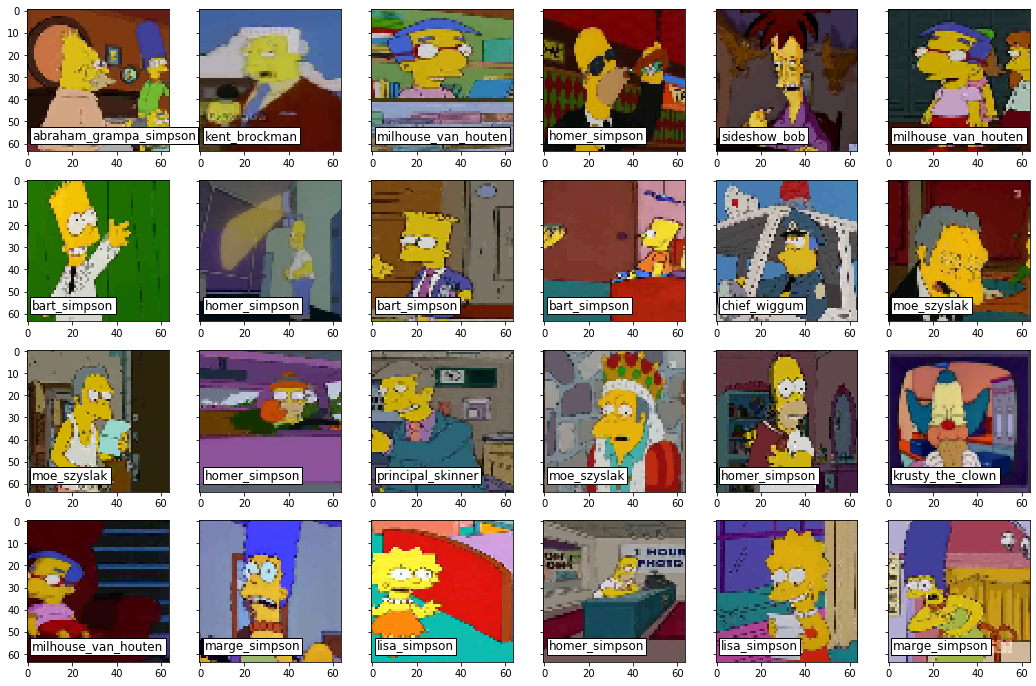

In [0]:
f, axes = plt.subplots(4, 6, sharey=True, figsize=(18, 12))
for i, ax in enumerate(axes.flat):
    show_image_from_path(ax, x_train_paths[i], y_train[i]) 

Функции для выдерания батч путей картинок и неспосредственно загрузка батч картинок

In [0]:
def load_from_paths(x_path_batch, img_size=64):
    batches = np.empty((len(x_path_batch), img_size, img_size, 3))

    for i, x_path_i in enumerate(x_path_batch):
        img = cv2.imread(x_path_i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype('float32') / 255.
        assert img.min() >= 0.0 and img.max() <= 1.0
        batches[i] = img
    return batches

def load_from_paths_batch(x_path, y, batch_size, img_size=64):
    SEED = 42
    np.random.seed(SEED)
    
    n_batch = len(x_path) // batch_size
    while (True):
        indices = np.arange(x_path.shape[0])
        np.random.shuffle(indices)
        x_path_take = x_path.take(indices, axis=0)
        y_take = y.take(indices, axis=0)

        for i in range(0, len(x_path), batch_size):
            x_path_batch = x_path_take[i : i + batch_size]
            y_batch = y_take[i : i + batch_size]
            batches = load_from_paths(x_path_batch, img_size)
            yield (batches, y_batch)

Проверим, что они корректно работают:

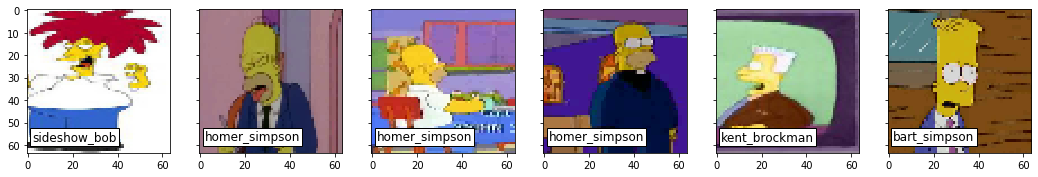

In [0]:
n_image = 6
gen = load_from_paths_batch(x_train_paths, y_train, n_image)
(im, index) = gen.__next__()
f, axes = plt.subplots(1, n_image, sharey=True, figsize=(3*n_image, 3))
for i, ax in enumerate(axes):
    show_image(ax, im[i], index[i])

Валидироваться будем на валидационном датасете, который выделим из тренировочного.

In [0]:
def split_data_set(X, Y):
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.01, random_state=777)
    return x_train, x_val, y_train, y_val

In [0]:
x_train_paths, x_val_paths, y_train, y_val = split_data_set(x_train_paths, y_train)
"train size {} validation size {}".format(x_train_paths.shape, x_val_paths.shape)

'train size (18802,) validation size (190,)'

Тестовая выборка состоит из 50 картнинок на каждого персонажа. Но использовать тестовые данные будем **только на финальной модели** в каждой лабораторной.

Методы для тренировки и тестирования наших моделей:

In [0]:
def train_model(model, X_train, Y_train, X_val, Y_val, epoch, batch_size, img_size=64, verbose=1):
    SEED = 65
    import random 
    random.seed(SEED)
    np.random.seed(SEED)
    
    n_batch = len(X_train) // batch_size
    X_val = load_from_paths(X_val, img_size)
    generator = load_from_paths_batch(X_train, Y_train, batch_size, img_size)
    model.fit_generator(generator, steps_per_epoch=n_batch, epochs=epoch, verbose=verbose, validation_data=[X_val, Y_val])
    return model
    
def test_model(model, x_test, img_size=64):
    x_test = load_from_paths(x_test)
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, 1)
    return y_pred

### Полносвязанные архитектуры

Создадим простую классическую двухслойную полносвязнную сеть:

$$n \times 64 \times 64 \times 3 \rightarrow n \times 128 \rightarrow RELU \rightarrow n \times 18 \rightarrow SOFTMAX$$

В качестве оптимизатора будем брать адаптивный градиент.

В качестве метрики для многоклассовой задачи возьмем **accuracy**

In [0]:
def build_dense_baseline_model():
    import keras.layers as L

    model = keras.models.Sequential()

    model.add(keras.layers.Flatten(input_shape=(64,64,3)))
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(len(map_characters)))
    model.add(keras.layers.Softmax())

    model.compile(
        optimizer="adam", 
        loss=keras.losses.sparse_categorical_crossentropy, 
        metrics=[keras.metrics.sparse_categorical_accuracy]
    )
    return model

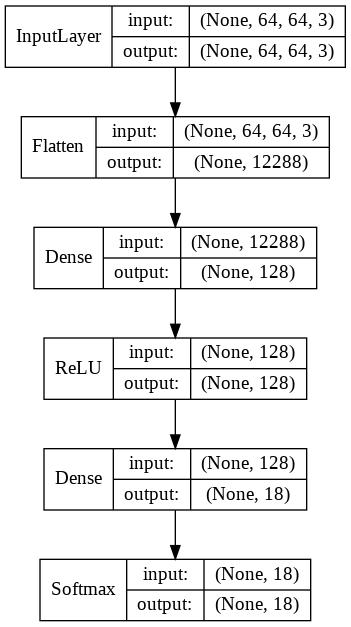

In [0]:
model = build_dense_baseline_model()
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=False)

In [0]:
train_model(model, x_train_paths, y_train, x_val_paths, y_val, epoch=15, batch_size=512, img_size=64)


Epoch 1/15
36/36 [==============================] - 136s 4s/step - loss: 4.2023 - sparse_categorical_accuracy: 0.0659 - val_loss: 2.8712 - val_sparse_categorical_accuracy: 0.0684
Epoch 2/15
36/36 [==============================] - 48s 1s/step - loss: 2.8561 - sparse_categorical_accuracy: 0.0770 - val_loss: 2.8465 - val_sparse_categorical_accuracy: 0.0895
Epoch 3/15
36/36 [==============================] - 45s 1s/step - loss: 2.8331 - sparse_categorical_accuracy: 0.0911 - val_loss: 2.8160 - val_sparse_categorical_accuracy: 0.1263
Epoch 4/15
36/36 [==============================] - 46s 1s/step - loss: 2.8010 - sparse_categorical_accuracy: 0.1081 - val_loss: 2.7963 - val_sparse_categorical_accuracy: 0.1316
Epoch 5/15
36/36 [==============================] - 46s 1s/step - loss: 2.7681 - sparse_categorical_accuracy: 0.1210 - val_loss: 2.7592 - val_sparse_categorical_accuracy: 0.1368
Epoch 6/15
36/36 [==============================] - 46s 1s/step - loss: 2.7329 - sparse_categorical_accuracy

На валидационном датасете мы достигли **0.2 аккурсаси**. Из основных выводом которые можно сделать - мы пока **сильно недобучаемся**. Усложим немного модель дополнив дополнительным полносвязанным слоем:

$$n \times 64 \times 64 \times 3 \rightarrow n \times 1024 \rightarrow RELU \rightarrow n \times 128 \rightarrow RELU \rightarrow n \times 18 \rightarrow SOFTMAX$$


In [0]:
def build_dense_v1_model():
    import keras.layers as L

    model = keras.models.Sequential()

    model.add(keras.layers.Flatten(input_shape=(64,64,3)))
    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.ReLU())
    
    model.add(keras.layers.Dense(len(map_characters)))
    model.add(keras.layers.Softmax())

    model.compile(
        optimizer="adam", 
        loss=keras.losses.sparse_categorical_crossentropy, 
        metrics=[keras.metrics.sparse_categorical_accuracy]
    )
    return model

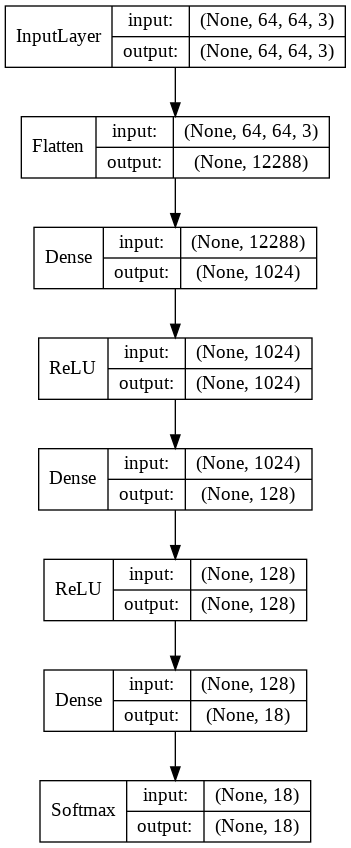

In [0]:
model = build_dense_v1_model()
plot_model(model, show_shapes=True, show_layer_names=False)

In [0]:
train_model(model, x_train_paths, y_train, x_val_paths, y_val, epoch=15, batch_size=512, img_size=64)

Epoch 1/15
36/36 [==============================] - 51s 1s/step - loss: 5.3481 - sparse_categorical_accuracy: 0.0968 - val_loss: 2.7379 - val_sparse_categorical_accuracy: 0.1421
Epoch 2/15
36/36 [==============================] - 46s 1s/step - loss: 2.6652 - sparse_categorical_accuracy: 0.1734 - val_loss: 2.6451 - val_sparse_categorical_accuracy: 0.1895
Epoch 3/15
36/36 [==============================] - 46s 1s/step - loss: 2.5721 - sparse_categorical_accuracy: 0.2070 - val_loss: 2.5925 - val_sparse_categorical_accuracy: 0.1947
Epoch 4/15
36/36 [==============================] - 46s 1s/step - loss: 2.5088 - sparse_categorical_accuracy: 0.2272 - val_loss: 2.5237 - val_sparse_categorical_accuracy: 0.2000
Epoch 5/15
36/36 [==============================] - 46s 1s/step - loss: 2.4473 - sparse_categorical_accuracy: 0.2440 - val_loss: 2.4896 - val_sparse_categorical_accuracy: 0.2158
Epoch 6/15
36/36 [==============================] - 46s 1s/step - loss: 2.3761 - sparse_categorical_accuracy: 

Неплохо улучшилась модель на валидационной выборке с **0.2** мы поднялись до **0.36**, однако мы до сих недообучаемся.

Для исскуственного увеличения исходной выборки можем попробовать использовать аутментацию - каждое изображение может быть видоизменено для создания новых экземпляров. Под видоизменением могут подразумеваться сдвиги, повороты, зеркальные отражения и прочее. В библиотеке Keras для аугментации существует класс **ImageDataGenerator**. В частности, у генератора с аугментацией есть возможность загружать сэмплы из конкретной директории, чем мы и воспользуемся:

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
def create_augmentation_generator(img_size=64, batch_size=256):
    dataset_dir = 'simpsons_dataset/'

    datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False
    )
    
    generator = datagen.flow_from_directory(
        directory=dataset_dir,
        target_size=(img_size,img_size),
        color_mode='rgb',
        class_mode='sparse',
        batch_size=batch_size,
        classes=map_characters.values()
    )

    return generator

Примеры результата аугментации

Found 18992 images belonging to 18 classes.


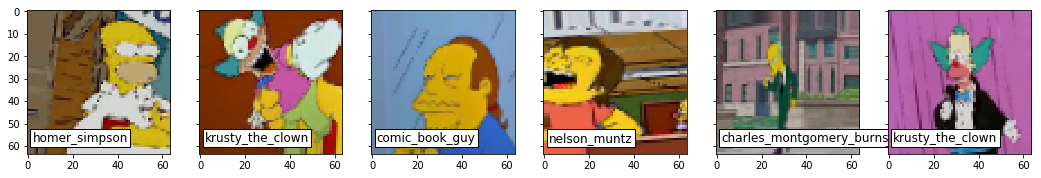

In [0]:
generator = create_augmentation_generator()
n_image = 6
(im, index) = generator.__next__()
f, axes = plt.subplots(1, n_image, sharey=True, figsize=(3*n_image, 3))
for i, ax in enumerate(axes):
    show_image(ax, im[i], index[i])

In [0]:
def train_model_augmentation(model, X_train, Y_train, X_val, Y_val, epoch, batch_size, img_size=64, verbose=1):
    SEED = 65
    import random 
    random.seed(SEED)
    np.random.seed(SEED)
    
    n_batch = len(X_train) // batch_size
    X_val = load_from_paths(X_val, img_size)
   
    generator = create_augmentation_generator(img_size, batch_size)
    
    model.fit_generator(generator, steps_per_epoch=n_batch, epochs=epoch, verbose=verbose, validation_data=[X_val, Y_val])
    return model

In [0]:
model = build_dense_v1_model()
train_model_augmentation(model, x_train_paths, y_train, x_val_paths, y_val, epoch=10, batch_size=512, img_size=64)

Found 18992 images belonging to 18 classes.
Epoch 1/10
36/36 [==============================] - 115s 3s/step - loss: 5.3845 - sparse_categorical_accuracy: 0.0910 - val_loss: 2.7083 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/10
36/36 [==============================] - 104s 3s/step - loss: 2.6956 - sparse_categorical_accuracy: 0.1616 - val_loss: 2.5908 - val_sparse_categorical_accuracy: 0.2000
Epoch 3/10
36/36 [==============================] - 105s 3s/step - loss: 2.6103 - sparse_categorical_accuracy: 0.1950 - val_loss: 2.5071 - val_sparse_categorical_accuracy: 0.2211
Epoch 4/10
36/36 [==============================] - 119s 3s/step - loss: 2.5695 - sparse_categorical_accuracy: 0.2102 - val_loss: 2.4577 - val_sparse_categorical_accuracy: 0.2368
Epoch 5/10
36/36 [==============================] - 103s 3s/step - loss: 2.5368 - sparse_categorical_accuracy: 0.2169 - val_loss: 2.4522 - val_sparse_categorical_accuracy: 0.2526
Epoch 6/10
36/36 [==============================] - 102s 3s/s

Аугментация не очень погает нам, почти Лосс никуда не сходится, да и работает очень медленно с ней. Оставим пока оригинальный датасет для экспериментов.

Трехслойная сеть очень долго работает у нас. Попробуем оставить двухслойную и подобрать количество скрытых нейронов и функцию активации прямым перебором.

$$n \times 64 \times 64 \times 3 \rightarrow n \times \textbf s \rightarrow \textbf {act} \rightarrow n \times 18 \rightarrow SOFTMAX$$
$$ \textbf s \in \{256, 512, 1024\}; \textbf {act} = \{relu, selu, sigmoid\}$$

In [0]:
def build_dense_custom_model(s=128, act='relu'):
    import keras.layers as L

    model = keras.models.Sequential()

    model.add(keras.layers.Flatten(input_shape=(64, 64, 3)))
    model.add(keras.layers.Dense(s, activation=act))
    
    model.add(keras.layers.Dense(len(map_characters)))
    model.add(keras.layers.Softmax())

    model.compile(
        optimizer="adam", 
        loss=keras.losses.sparse_categorical_crossentropy, 
        metrics=[keras.metrics.sparse_categorical_accuracy]
    )
    return model

In [0]:
%%time
activation_params = ['selu', 'relu', 'sigmoid' ]
s_params = [256, 512, 1024]

for s in s_params:
    for activation in activation_params:
        model = build_dense_custom_model(s, activation)
        train_model_augmentation(model, x_train_paths, y_train, x_val_paths, y_val, epoch=10, batch_size=512, verbose=0)
        y_pred = test_model(model, x_val_paths, y_val)
        accuracy = (y_val == y_pred).mean()
        print('s = {:4d} |  activataion = {:10s} | acc = {:3.2f}'.format(s, activation, accuracy)) 

Found 18992 images belonging to 18 classes.
s =  256 |  activataion = selu       | acc = 0.41
Found 18992 images belonging to 18 classes.
s =  256 |  activataion = relu       | acc = 0.36
Found 18992 images belonging to 18 classes.
s =  256 |  activataion = sigmoid    | acc = 0.28
Found 18992 images belonging to 18 classes.
s =  512 |  activataion = selu       | acc = 0.38
Found 18992 images belonging to 18 classes.
s =  512 |  activataion = relu       | acc = 0.38
Found 18992 images belonging to 18 classes.
s =  512 |  activataion = sigmoid    | acc = 0.32
Found 18992 images belonging to 18 classes.
s = 1024 |  activataion = selu       | acc = 0.42
Found 18992 images belonging to 18 classes.
s = 1024 |  activataion = relu       | acc = 0.37
Found 18992 images belonging to 18 classes.
s = 1024 |  activataion = sigmoid    | acc = 0.36
CPU times: user 2h 17min 1s, sys: 15min 36s, total: 2h 32min 37s
Wall time: 3h 46min 10s


| Model                            | validate accuracy |
|----------------------------------|-------------------|
|s =  256 ; activataion = selu     | 0.41  |
|s =  256 ;  activataion = relu    | 0.36  |
|s =  256 ;  activataion = sigmoid | 0.28  |
|s =  512 ;  activataion = selu    | 0.38  |
|s =  512 ;  activataion = relu    | 0.38  |
|s =  512 ;  activataion = sigmoid | 0.32  |
|s = 1024 ;  activataion = selu    | 0.42  |
|s = 1024 ;  activataion = relu    | 0.37  |
|s = 1024 ;  activataion = sigmoid | 0.36  |

Лучше всего получилось аккурсаси на валидационной выборке, аж **~0.41** при небольшом количество эпох. Оставим эту финальную модель для первой лабораторной. Увеличим количество эпох для финальной модели 1-ой лабораторной.

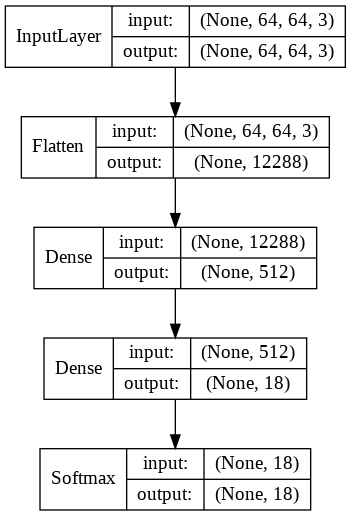

In [0]:
model = build_dense_custom_model(s=512, act='relu')
plot_model(model, show_shapes=True, show_layer_names=False)

In [0]:
%%time
train_model(model, x_train_paths, y_train, x_val_paths, y_val, epoch=20, batch_size=512, verbose=0)

CPU times: user 32min 54s, sys: 3min 35s, total: 36min 30s
Wall time: 15min 25s


Проверим на валидации

In [0]:
y_pred = test_model(model, x_val_paths, y_val)
(y_val == y_pred).mean()

0.47368421052631576

Супер! Посмотрим на тестовой выборке результат.

### Финальный результат на тестовой выборке

In [0]:
x_test_paths, y_test = collect_test_paths()
x_test_paths.shape, y_test.shape

((890,), (890,))

In [0]:
def visualize_results(x_test, y_pred):
    y_pred = list(map(lambda y_pred_i: sorted(zip(map_characters.values(), y_pred_i), key=lambda kv: kv[1], reverse=True)[:3], y_pred))

    indices = np.arange(x_test.shape[0])
    np.random.shuffle(indices)

    f, axes = plt.subplots(4, 6, sharey=True, figsize=(18, 12))
    for i, ax in enumerate(axes.flat):
        show_image_with_dict(ax, x_test[i], y_pred[i])        

'Аккураси на тестовой выборки: 0.5202247191011236'

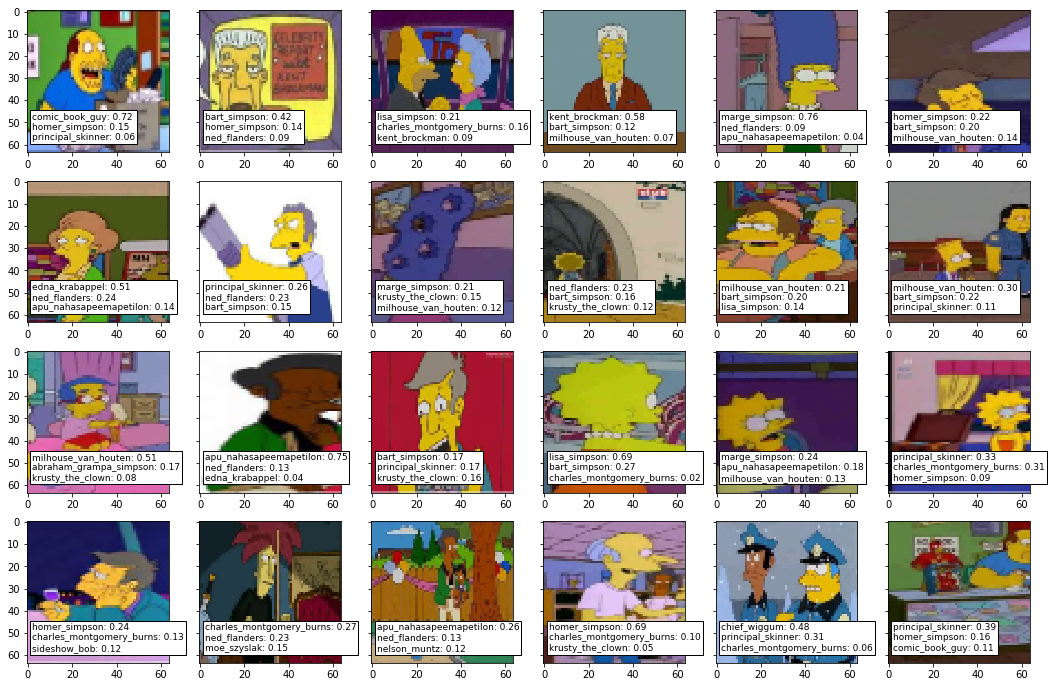

In [0]:
x_test = load_from_paths(x_test_paths)
y_pred = model.predict(x_test)

visualize_results(x_test, y_pred)
y_pred = np.argmax(y_pred, 1)

"Аккураси на тестовой выборки: {}".format((y_test == y_pred).mean())

In [0]:
print(sklearn.metrics.classification_report(y_test,
    y_pred, target_names=list(map_characters.values())), sep='')

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.58      0.23      0.33        48
  apu_nahasapeemapetilon       0.66      0.76      0.70        50
            bart_simpson       0.30      0.54      0.38        50
charles_montgomery_burns       0.50      0.58      0.54        48
            chief_wiggum       0.82      0.56      0.67        50
          comic_book_guy       0.83      0.31      0.45        49
          edna_krabappel       0.66      0.46      0.54        50
           homer_simpson       0.28      0.68      0.39        50
           kent_brockman       0.93      0.56      0.70        50
        krusty_the_clown       0.60      0.72      0.65        50
            lisa_simpson       0.65      0.22      0.33        50
           marge_simpson       0.70      0.64      0.67        50
     milhouse_van_houten       0.48      0.55      0.51        49
             moe_szyslak       0.81      0.44      0.57        50
         

Хуже всех предсказывается Гомер Симспон, скорее всего потому что, он наделен меньшим количевом уникальных признаков. А лучше всех Кент Брокман, Мо, Нельсон и прочие выделяющиеся персонажи. Для двух полносвязанных слоев с аккурси **0.52** совсем не плохо. Идем дальше!

In [0]:
models = {
    'baseline_model': build_dense_baseline_model(),
    'improved_model': build_dense_v1_model(),
    'custom_model': build_dense_custom_model(s=512, act='relu')
}

x_test_paths, y_test = collect_test_paths()

for model_name, model in models.items():
    print(model_name)

    start = time.time()
    train_model(model, x_train_paths, y_train, x_val_paths, y_val, epoch=15, batch_size=512, img_size=64)
    end = time.time()
    print("Time(sec): \t ", end - start)

    pred_train  = test_model(model, x_train_paths, img_size=64)
    print("Training: \t" , (pred_train == y_train).mean())

    pred_val  = test_model(model, x_val_paths, img_size=64)
    print("Validation: \t" , (pred_val == y_val).mean())

    pred_test = test_model(model, x_test_paths, img_size=64)
    print("Test: \t" , (pred_test == y_test).mean())

    print("########################################")

baseline_model
Epoch 1/15
36/36 [==============================] - 51s 1s/step - loss: 3.7452 - sparse_categorical_accuracy: 0.1573 - val_loss: 3.0629 - val_sparse_categorical_accuracy: 0.2842
Epoch 2/15
36/36 [==============================] - 49s 1s/step - loss: 2.7830 - sparse_categorical_accuracy: 0.2573 - val_loss: 2.4600 - val_sparse_categorical_accuracy: 0.2684
Epoch 3/15
36/36 [==============================] - 49s 1s/step - loss: 2.3814 - sparse_categorical_accuracy: 0.2981 - val_loss: 2.3513 - val_sparse_categorical_accuracy: 0.2895
Epoch 4/15
36/36 [==============================] - 49s 1s/step - loss: 2.2428 - sparse_categorical_accuracy: 0.3294 - val_loss: 2.2171 - val_sparse_categorical_accuracy: 0.3105
Epoch 5/15
36/36 [==============================] - 49s 1s/step - loss: 2.1371 - sparse_categorical_accuracy: 0.3632 - val_loss: 2.1711 - val_sparse_categorical_accuracy: 0.3316
Epoch 6/15
36/36 [==============================] - 49s 1s/step - loss: 2.0636 - sparse_categor